In [2]:
import openturns as ot
import importlib.util
import sys
import os
import pandas as pd

# Load the flood model
module_name = "FloodModel"
file_path = "examples/Water.py"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist.")

spec = importlib.util.spec_from_file_location(module_name, file_path)
if spec is None:
    raise ImportError(f"Could not load the module from {file_path}.")

module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

function_of_interest, problem = module.model, module.problem

# Create distributions
distributions = ot.DistributionCollection()
for dist_info in problem['distributions']:
    dist_type = dist_info['type']
    params = dist_info['params']
    if dist_type == 'Uniform':
        distributions.add(ot.Uniform(*params))
    elif dist_type == 'Normal':
        distributions.add(ot.Normal(*params))
    elif dist_type == 'LogNormalMuSigma':
        distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
    elif dist_type == 'LogNormal':
        distributions.add(ot.LogNormal(*params))
    elif dist_type == 'Beta':
        distributions.add(ot.Beta(*params))
    elif dist_type == 'Gumbel':
        distributions.add(ot.Gumbel(*params))
    elif dist_type == 'Triangular':
        distributions.add(ot.Triangular(*params))
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")

distribution = ot.ComposedDistribution(distributions)

# Define the OpenTURNS model
ot_model = ot.PythonFunction(problem['num_vars'], 1, function_of_interest)

# Draw the function
n = 10000
sampleX = distribution.getSample(n)
sampleY = ot_model(sampleX)

# Save data used in plotXvsY to CSV
combined_sample = ot.Sample(sampleY.getSize(), sampleX.getDimension() + 1)
for i in range(sampleY.getSize()):
    combined_sample[i, 0] = sampleY[i]
    combined_sample[i, 1:] = sampleX[i]

combined_sample.setDescription(["model_output"] + problem['names'])
combined_sample.exportToCSVFile("results/plotXvsY_data.csv")

# Estimate the Sobol' indices
size = 1000
sie = ot.SobolIndicesExperiment(distribution, size)
inputDesign = sie.generate()
input_names = problem['names']
inputDesign.setDescription(input_names)
inputDesign.getSize()

outputDesign = ot_model(inputDesign)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

# Use the provided code to create DataFrames for Sobol indices
rows = str(sensitivityAnalysis.getFirstOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getFirstOrderIndices()).strip('[]').split(',')))})
first_order_df = pd.concat([new_df, df], axis=1)

rows = str(sensitivityAnalysis.getTotalOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getTotalOrderIndices()).strip('[]').split(',')))})
total_order_df = pd.concat([new_df, df], axis=1)

# Save Sobol indices to CSV
first_order_df.to_csv("results/first_order_sobol_indices.csv", index=False)
total_order_df.to_csv("results/total_order_sobol_indices.csv", index=False)


TypeError: InvalidArgumentException : Object passed as argument is not a double

In [26]:
combined_sample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10000 dimension=9 data=[[0,0,0,...,0,0,0],[0,0,0,...,0,0,0],[0,0,0,...,0,0,0],...,[0,0,0,...,0,0,0],[0,0,0,...,0,0,0],[0,0,0,...,0,0,0]]

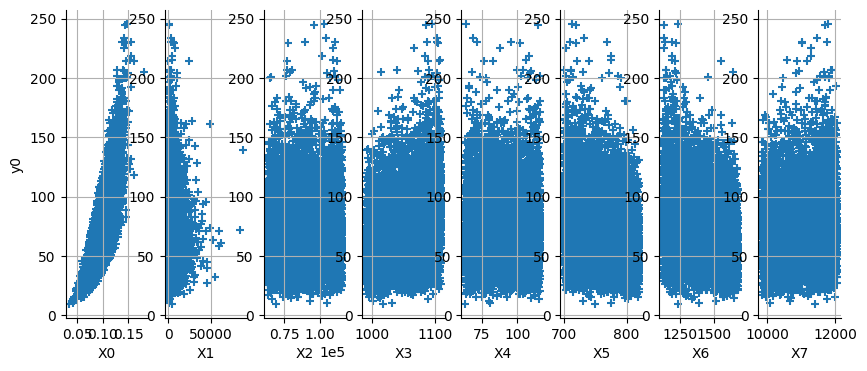

In [21]:
"""
Estimate Sobol' indices for the Flood model by a sampling method
================================================================
"""

import openturns as ot
import importlib.util
import sys
import os
import openturns.viewer as otv
from matplotlib import pylab as plt
import pandas as pd

# Load the flood model
module_name = "FloodModel"
file_path = "examples/Water.py"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist.")

spec = importlib.util.spec_from_file_location(module_name, file_path)
if spec is None:
    raise ImportError(f"Could not load the module from {file_path}.")

module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

function_of_interest, problem = module.model, module.problem

# Create distributions
distributions = ot.DistributionCollection()
for dist_info in problem['distributions']:
    dist_type = dist_info['type']
    params = dist_info['params']
    if dist_type == 'Uniform':
        distributions.add(ot.Uniform(*params))
    elif dist_type == 'Normal':
        distributions.add(ot.Normal(*params))
    elif dist_type == 'LogNormalMuSigma':
        distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
    elif dist_type == 'LogNormal':
        distributions.add(ot.LogNormal(*params))
    elif dist_type == 'Beta':
        distributions.add(ot.Beta(*params))
    elif dist_type == 'Gumbel':
        distributions.add(ot.Gumbel(*params))
    elif dist_type == 'Triangular':
        distributions.add(ot.Triangular(*params))
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")

distribution = ot.ComposedDistribution(distributions)

# Define the OpenTURNS model
ot_model = ot.PythonFunction(problem['num_vars'], 1, function_of_interest)

# Draw the function
n = 10000
sampleX = distribution.getSample(n)
sampleY = ot_model(sampleX)

# Inline code for plotXvsY
dimX = sampleX.getDimension()
dimY = sampleY.getDimension()
descriptionX = sampleX.getDescription()
descriptionY = sampleY.getDescription()
grid = ot.GridLayout(dimY, dimX)
for i in range(dimY):
    for j in range(dimX):
        graph = ot.Graph("", descriptionX[j], descriptionY[i], True, "")
        cloud = ot.Cloud(sampleX[:, j], sampleY[:, i])
        graph.add(cloud)
        if j == 0:
            graph.setYTitle(descriptionY[i])
        else:
            graph.setYTitle("")
        if i == dimY - 1:
            graph.setXTitle(descriptionX[j])
        else:
            graph.setXTitle("")
        grid.setGraph(i, j, graph)
_ = ot.viewer.View(grid, figure_kw={"figsize": (10.0, 4.0)})



sampleX.exportToCSVFile("results_tmp/X.csv", ",")
sampleY.exportToCSVFile("results_tmp/Y.csv", ",")


X = pd.read_csv('results_tmp/X.csv')
Y = pd.read_csv('results_tmp/Y.csv')

X.columns = problem['names']

grid_df = pd.concat([Y, X], axis=1)
grid_df.to_csv('results_tmp/grid.csv')

In [26]:
df

,y0
0,90.974958
1,138.504222
2,34.118003
3,138.573616
4,43.628293
...,...
9995,68.277448
9996,54.411837
9997,44.998991
9998,55.918947


In [31]:
X

,Unnamed: 0,rw,r,Tu,Hu,Tl,Hl,L,Kw
0,0,0.117490,13576.471218,111884.886366,1017.838967,95.597215,741.715531,1290.191281,9865.276855
1,1,0.133085,1449.967766,101898.514303,1102.006180,78.690148,742.423028,1483.124806,10341.662711
2,2,0.069252,560.045880,98009.100807,1019.121909,77.438453,701.745852,1558.734451,11143.756682
3,3,0.129654,2422.506790,100145.307931,1091.197488,64.548706,781.593497,1337.952155,11464.017408
4,4,0.095345,4115.773581,104681.484385,1018.449275,103.640277,784.907479,1511.819916,9919.446840
...,...,...,...,...,...,...,...,...,...
9995,9995,0.093917,3618.064582,114537.062908,1081.897468,83.930235,715.495124,1494.634471,10088.922247
9996,9996,0.096527,2202.071026,110522.382825,1052.049678,67.099674,791.457127,1638.526520,11746.345429
9997,9997,0.074289,308.491581,101546.277484,1087.045869,66.773932,747.650387,1538.851510,11799.023715
9998,9998,0.092855,9007.868361,72169.338241,1020.844087,105.935161,717.117311,1672.790042,11406.284933


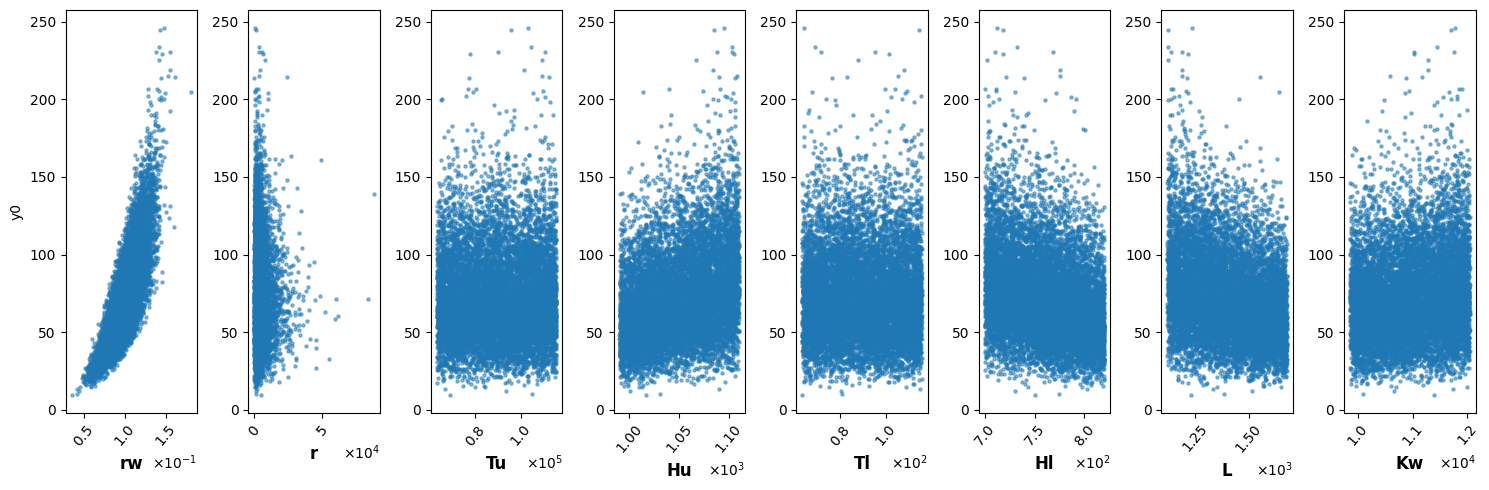

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Load the CSV file
csv_file = 'results_tmp/grid.csv'

df = pd.read_csv(csv_file)

# Extract the columns
y = df['y0']
X = df.drop(columns=['y0', 'Unnamed: 0'])

# Get the column names
X_names = X.columns

# Define the dimensions
dimX = X.shape[1]

# Create a grid of plots
fig, axes = plt.subplots(1, dimX, figsize=(15, 5))

# Plot each subplot
for j in range(dimX):
    ax = axes[j] if dimX > 1 else axes
    ax.scatter(X.iloc[:, j], y, alpha=0.5, s=5)
    ax.set_xlabel(X_names[j], fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=50)  # Rotate x-ticks vertically
    if j == 0:
        ax.set_ylabel('y0')
    else:
        ax.set_ylabel("")
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

plt.tight_layout()
plt.show()



In [ ]:
# Estimate the Sobol' indices
size = 1000
sie = ot.SobolIndicesExperiment(distribution, size)
inputDesign = sie.generate()
input_names = problem['names']
inputDesign.setDescription(input_names)
inputDesign.getSize()

outputDesign = ot_model(inputDesign)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

first_order_indices = sensitivityAnalysis.getFirstOrderIndices()
total_order_indices = sensitivityAnalysis.getTotalOrderIndices()

print("First Order Indices:", first_order_indices)
print("Total Order Indices:", total_order_indices)


# put Sobol data to DataFrames
rows = str(sensitivityAnalysis.getFirstOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getFirstOrderIndices()).strip('[]').split(',')))})
first_order_df = pd.concat([new_df, df], axis=1)


rows = str(sensitivityAnalysis.getTotalOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getTotalOrderIndices()).strip('[]').split(',')))})
total_order_df = pd.concat([new_df, df], axis=1)





graph = sensitivityAnalysis.draw()
view = otv.View(graph)

# Estimate the second order indices
size = 1000
computeSecondOrder = True
sie = ot.SobolIndicesExperiment(distribution, size, computeSecondOrder)
inputDesign = sie.generate()
inputDesign.setDescription(input_names)
outputDesign = ot_model(inputDesign)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

second_order = sensitivityAnalysis.getSecondOrderIndices()
for i in range(len(problem['names'])):
    for j in range(i):
        print("2nd order index (%d,%d)=%g" % (i, j, second_order[i, j]))

# Using a different estimator
sensitivityAnalysis = ot.MartinezSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = otv.View(graph)

plt.show()


In [19]:
str(sensitivityAnalysis.getFirstOrderIndices())


'[0.636333,0.0274059,0.0273442,0.110478,0.0274192,0.12607,0.116715,0.0423708]'

In [16]:
sensitivityAnalysis.getFirstOrderIndicesInterval()

class=Interval name=Unnamed dimension=8 lower bound=class=Point name=Unnamed dimension=8 values=[0.597537,-0.0404089,-0.0404435,0.0425612,-0.0404875,0.0503884,0.0465266,-0.0252676] upper bound=class=Point name=Unnamed dimension=8 values=[0.681554,0.100795,0.100707,0.183233,0.100868,0.209312,0.187712,0.115603] finite lower bound=[1,1,1,1,1,1,1,1] finite upper bound=[1,1,1,1,1,1,1,1]

In [15]:
str(sensitivityAnalysis.getFirstOrderIndicesInterval())

'[0.597537, 0.681554]\n[-0.0404089, 0.100795]\n[-0.0404435, 0.100707]\n[0.0425612, 0.183233]\n[-0.0404875, 0.100868]\n[0.0503884, 0.209312]\n[0.0465266, 0.187712]\n[-0.0252676, 0.115603]'

In [20]:
list(map(float, str(sensitivityAnalysis.getFirstOrderIndices()).strip('[]').split(',')))


[0.636333,
 0.0274059,
 0.0273442,
 0.110478,
 0.0274192,
 0.12607,
 0.116715,
 0.0423708]

In [21]:

rows = str(sensitivityAnalysis.getFirstOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getFirstOrderIndices()).strip('[]').split(',')))})
first_order_df = pd.concat([new_df, df], axis=1)
first_order_df


rows = str(sensitivityAnalysis.getTotalOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getTotalOrderIndices()).strip('[]').split(',')))})
Total_order_df = pd.concat([new_df, df], axis=1)



,Sobol Index,Upper Bound,Lower Bound
0,0.636333,0.597537,0.681554
1,0.027406,-0.040409,0.100795
2,0.027344,-0.040444,0.100707
3,0.110478,0.042561,0.183233
4,0.027419,-0.040488,0.100868
5,0.126070,0.050388,0.209312
6,0.116715,0.046527,0.187712
7,0.042371,-0.025268,0.115603


In [22]:

rows = str(sensitivityAnalysis.getTotalOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getTotalOrderIndices()).strip('[]').split(',')))})
Total_order_df = pd.concat([new_df, df], axis=1)

,Sobol Index,Upper Bound,Lower Bound
0,6.771870e-01,0.527834,0.853846
1,3.314580e-06,-0.113825,0.148091
2,8.925370e-12,-0.113828,0.148087
3,1.023240e-01,-0.023686,0.263100
4,9.048980e-06,-0.113820,0.148096
5,1.078620e-01,-0.011614,0.263073
6,9.841530e-02,-0.020465,0.252460
7,2.545690e-02,-0.090388,0.176177
